In [53]:
from Autoencoder import *
from make_video import *

import cv2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer,Conv2D,MaxPool2D,\
UpSampling2D,Conv2DTranspose,Cropping2D,Add,add
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
                                                                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=(1024*4))])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Parameters

In [2]:
## For Current PC
# DATASET = r'C:\Users\Saad.LAKES\Desktop\Autoencoders\Videos\Dataset' ## where there is dataset
# DATASET_NAME = r'bunny_video.mp4' ## Name of the video
# FRAMES = r'C:\Users\Saad.LAKES\Desktop\Autoencoders\Videos\Results\Video_Frames' ## where you want to save the frames
# RECONSTRUCTED = r'C:\Users\Saad.LAKES\Desktop\Autoencoders\Videos\Results\ReconVideo_Frames' ## where the reconstructed frames are saved

## For NAON PC
DATASET = r'C:\Users\saad\Desktop\Autoencoders\Videos\Dataset' ## where there is dataset
DATASET_NAME = r'bunny_video.mp4' ## Name of the video
FRAMES = r'C:\Users\saad\Desktop\Autoencoders\Videos\Results\Video_Frames' ## where you want to save the frames
RECONSTRUCTED = r'C:\Users\saad\Desktop\Autoencoders\Videos\Results\ReconVideo_Frames' ## where the reconstructed frames are saved


WIDTH = 640 ## width of the reconstrcted image
HEIGHT = 480 ## height of the reconstrcted image
FPS = 25 ## fps of the reconstrcted image
SLICES = 2 ## Number of slices to be made on the image

EMBEDDING_SIZE = 512 ## bottleneck layer nodes

Loading Video...
Completed
The fps is 25.0, The width of the frame is 1280 and the height of the frame is 720
(1478, 480, 320, 3)


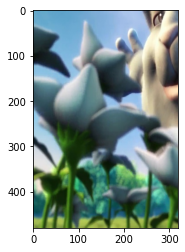

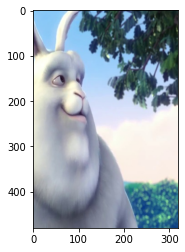

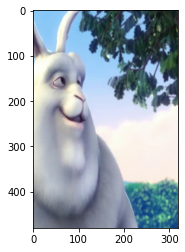

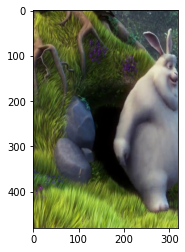

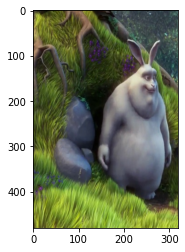

In [3]:
names,fps,width,height = read_video(FRAMES,os.path.join(DATASET,DATASET_NAME))

print(f'The fps is {fps}, The width of the frame is {width} and the height of the frame is {height}')

images1 = np.array(read_imgs(FRAMES,names,SLICES,WIDTH,HEIGHT))
print(images1.shape)
images = images1.astype('float32')/255.

## Sanity check on the images
ran = random.sample(range(0,len(images)),5)
for r in ran:
    plt.imshow(images[r])
    plt.show()

In [4]:
images.shape

(1478, 480, 320, 3)

In [5]:
train,test = splitter(images,0.1)
print(f'The shape of train is {train.shape}')
print(f'The shape of test is {test.shape}')

The shape of train is (1330, 480, 320, 3)
The shape of test is (148, 480, 320, 3)


In [6]:
## SSIM = 0.94
# The encoder
encoder = Sequential()
encoder.add(InputLayer((480,320,3)))
encoder.add(Conv2D(filters=32,kernel_size=3,strides=2,padding='same'))
encoder.add(Conv2D(filters=32,kernel_size=3,strides=2,padding='same'))
encoder.add(Conv2D(filters=32,kernel_size=3,strides=2,padding='same'))
encoder.add(Conv2D(filters=32,kernel_size=3,strides=2,padding='same'))

# The decoder
decoder = Sequential()
decoder.add(InputLayer((30,20,32)))
decoder.add(Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same'))
decoder.add(Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same'))
decoder.add(Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same'))
decoder.add(Conv2DTranspose(filters=3,kernel_size=3,strides=2,padding='same'))

In [63]:
## Residual Autoencoder - Take 1
# SSIM = 0.99

# The encoder
encoder_1 = Input((480,320,3),name='encoder_input')
encoder_2 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='ELayer1')(encoder_1)
encoder_3 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='ELayer2')(encoder_2)
encoder_4 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='ELayer3')(encoder_3)
encoder_5 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='ELayer4')(encoder_4)

# encoder = Model(encoder_1,encoder_5)

# The decoder
# decoder_1 = Input((30,20,32),name='decoder_input')
decoder_2 = Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',name='DLayer1')(encoder_5)
add_1 = add([decoder_2,encoder_4]) # Residual Network
decoder_3 = Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',name='DLayer2')(add_1)
decoder_4 = Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',name='DLayer3')(decoder_3)
add_2 = add([decoder_4,encoder_2]) # Residual Network
decoder_5 = Conv2DTranspose(filters=3,kernel_size=3,strides=2,padding='same',name='DLayer4')(add_2)

autoencoder = Model(encoder_1,decoder_5)

autoencoder.compile(optimizer='adam',loss='mse',metrics=['mae'])
autoencoder.summary()

Model: "functional_52"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 480, 320, 3) 0                                            
__________________________________________________________________________________________________
ELayer1 (Conv2D)                (None, 240, 160, 32) 896         encoder_input[0][0]              
__________________________________________________________________________________________________
ELayer2 (Conv2D)                (None, 120, 80, 32)  9248        ELayer1[0][0]                    
__________________________________________________________________________________________________
ELayer3 (Conv2D)                (None, 60, 40, 32)   9248        ELayer2[0][0]                    
______________________________________________________________________________________

In [111]:
## Hi-res Autoencoders

##################################
####### First Autoencoder ########
##################################

# The encoder 1
encoder1_1 = Input((480,320,3),name='encoder1_input')
encoder1_2 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='E1Layer1')(encoder1_1)
encoder1_3 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='E1Layer2')(encoder1_2)
encoder1_4 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='E1Layer3')(encoder1_3)
encoder1_5 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='E1Layer4')(encoder1_4)

encoder1 = Model(encoder1_1,encoder1_5)

# The decoder 1
decoder1_1 = Input((30,20,32),name='decoder1_input')
decoder1_2 = Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',name='D1Layer1')(decoder1_1)
decoder1_3 = Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',name='D1Layer2')(decoder1_2)
decoder1_4 = Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',name='D1Layer3')(decoder1_3)
decoder1_5 = Conv2DTranspose(filters=3,kernel_size=3,strides=2,padding='same',name='D1Layer4')(decoder1_4)

decoder1 = Model(decoder1_1,decoder1_5)

inp = Input((480,320,3))
code = encoder1(inp)
reconstruction = decoder1(code)
autoencoder1 = Model(inp,reconstruction)

##################################
####### Second Autoencoder #######
##################################

# The encoder 2
encoder2_1 = autoencoder1.output #Input((480,320,3),name='encoder2_input')
encoder2_2 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='E2Layer1')(encoder2_1)
encoder2_3 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='E2Layer2')(encoder2_2)
encoder2_4 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='E2Layer3')(encoder2_3)
encoder2_5 = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',name='E2Layer4')(encoder2_4)

# The decoder 2
decoder2_2 = Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',name='D2Layer1')(encoder2_5)
add2_1 = add([decoder2_2,encoder2_4]) # Residual Connection 
decoder2_3 = Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',name='D2Layer2')(add2_1)
decoder2_4 = Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',name='D2Layer3')(decoder2_3)
add2_2 = add([decoder2_4,encoder2_2]) # Residual Connection 
decoder2_5 = Conv2DTranspose(filters=3,kernel_size=3,strides=2,padding='same',name='D2Layer4')(add2_2)

# autoencoder2 = Model(encoder2_1,decoder2_5)

autoencoder = Model(autoencoder1.input,decoder2_5)

# autoencoder.compile(optimizer='adam',loss='mse',metrics=['mae'])
# autoencoder.summary()

In [113]:
autoencoder.summary()

Model: "functional_201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           [(None, 480, 320, 3) 0                                            
__________________________________________________________________________________________________
functional_195 (Functional)     (None, 30, 20, 32)   28640       input_34[0][0]                   
__________________________________________________________________________________________________
functional_197 (Functional)     (None, 480, 320, 3)  28611       functional_195[0][0]             
__________________________________________________________________________________________________
E2Layer1 (Conv2D)               (None, 240, 160, 32) 896         functional_197[0][0]             
_____________________________________________________________________________________

Epoch 1/200
240/240 [==============================] - 6s 23ms/step - loss: 0.0146 - mae: 0.0795 - val_loss: 0.0054 - val_mae: 0.0501
Epoch 2/200
240/240 [==============================] - 5s 22ms/step - loss: 0.0050 - mae: 0.0483 - val_loss: 0.0045 - val_mae: 0.0454
Epoch 3/200
240/240 [==============================] - 5s 22ms/step - loss: 0.0042 - mae: 0.0440 - val_loss: 0.0039 - val_mae: 0.0433
Epoch 4/200
240/240 [==============================] - 5s 22ms/step - loss: 0.0037 - mae: 0.0415 - val_loss: 0.0035 - val_mae: 0.0411
Epoch 5/200
240/240 [==============================] - 5s 22ms/step - loss: 0.0037 - mae: 0.0432 - val_loss: 0.0031 - val_mae: 0.0370
Epoch 6/200
240/240 [==============================] - 5s 22ms/step - loss: 0.0025 - mae: 0.0325 - val_loss: 0.0023 - val_mae: 0.0306
Epoch 7/200
240/240 [==============================] - 5s 23ms/step - loss: 0.0023 - mae: 0.0316 - val_loss: 0.0020 - val_mae: 0.0277
Epoch 8/200
240/240 [==============================] - 5s 22ms

240/240 [==============================] - 5s 22ms/step - loss: 7.7600e-04 - mae: 0.0177 - val_loss: 6.0905e-04 - val_mae: 0.0152
Epoch 60/200
240/240 [==============================] - 5s 22ms/step - loss: 5.8245e-04 - mae: 0.0143 - val_loss: 5.5800e-04 - val_mae: 0.0135
Epoch 61/200
240/240 [==============================] - 5s 22ms/step - loss: 5.5590e-04 - mae: 0.0134 - val_loss: 5.5984e-04 - val_mae: 0.0138
Epoch 62/200
240/240 [==============================] - 5s 22ms/step - loss: 5.7272e-04 - mae: 0.0143 - val_loss: 5.5733e-04 - val_mae: 0.0139
Epoch 63/200
240/240 [==============================] - 5s 22ms/step - loss: 8.8891e-04 - mae: 0.0205 - val_loss: 7.4797e-04 - val_mae: 0.0188
Epoch 64/200
240/240 [==============================] - 5s 22ms/step - loss: 5.6677e-04 - mae: 0.0138 - val_loss: 5.4731e-04 - val_mae: 0.0133
Epoch 65/200
240/240 [==============================] - 5s 22ms/step - loss: 5.4533e-04 - mae: 0.0132 - val_loss: 5.4485e-04 - val_mae: 0.0133
Epoch 66/200

240/240 [==============================] - 5s 22ms/step - loss: 5.1087e-04 - mae: 0.0129 - val_loss: 5.2056e-04 - val_mae: 0.0134
Epoch 117/200
240/240 [==============================] - 5s 22ms/step - loss: 5.2106e-04 - mae: 0.0134 - val_loss: 5.6586e-04 - val_mae: 0.0154
Epoch 118/200
240/240 [==============================] - 5s 22ms/step - loss: 5.4665e-04 - mae: 0.0144 - val_loss: 5.8901e-04 - val_mae: 0.0156
Epoch 119/200
240/240 [==============================] - 5s 22ms/step - loss: 5.2634e-04 - mae: 0.0137 - val_loss: 5.1161e-04 - val_mae: 0.0130
Epoch 120/200
240/240 [==============================] - 5s 22ms/step - loss: 5.1612e-04 - mae: 0.0133 - val_loss: 5.4020e-04 - val_mae: 0.0143
Epoch 121/200
240/240 [==============================] - 5s 22ms/step - loss: 6.3217e-04 - mae: 0.0161 - val_loss: 5.4054e-04 - val_mae: 0.0143
Epoch 122/200
240/240 [==============================] - 5s 22ms/step - loss: 5.1864e-04 - mae: 0.0134 - val_loss: 5.1194e-04 - val_mae: 0.0131
Epoch 

240/240 [==============================] - 5s 22ms/step - loss: 6.3427e-04 - mae: 0.0146 - val_loss: 6.2714e-04 - val_mae: 0.0146
Epoch 174/200
240/240 [==============================] - 5s 22ms/step - loss: 6.3234e-04 - mae: 0.0148 - val_loss: 6.5077e-04 - val_mae: 0.0160
Epoch 175/200
240/240 [==============================] - 5s 22ms/step - loss: 6.4933e-04 - mae: 0.0155 - val_loss: 6.0582e-04 - val_mae: 0.0142
Epoch 176/200
240/240 [==============================] - 5s 22ms/step - loss: 6.1596e-04 - mae: 0.0147 - val_loss: 5.9763e-04 - val_mae: 0.0141
Epoch 177/200
240/240 [==============================] - 5s 22ms/step - loss: 6.2691e-04 - mae: 0.0151 - val_loss: 5.9396e-04 - val_mae: 0.0144
Epoch 178/200
240/240 [==============================] - 5s 22ms/step - loss: 5.9336e-04 - mae: 0.0143 - val_loss: 6.0643e-04 - val_mae: 0.0152
Epoch 179/200
240/240 [==============================] - 5s 22ms/step - loss: 8.1382e-04 - mae: 0.0198 - val_loss: 6.8995e-04 - val_mae: 0.0174
Epoch 

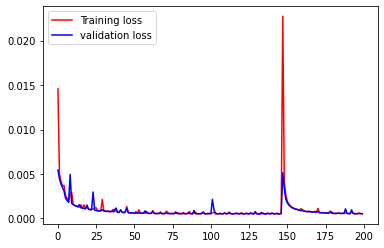

In [118]:
autoencoder.compile(loss='mse',optimizer='adam',metrics=['mae'])
filepath = 'wieghts_hires.hdf5'
checkpoint = ModelCheckpoint(filepath,monitor='val_loss',verbose=0,save_best_only=True,mode=min)
history = autoencoder.fit(train,train,epochs=200,batch_size=5,validation_split=0.1,callbacks=[checkpoint])

plt.plot(history.history['loss'],'r',label='Training loss')
plt.plot(history.history['val_loss'],'b',label='validation loss')
plt.legend()
plt.show()

In [89]:
encoder.summary()

Model: "functional_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 480, 320, 3)]     0         
_________________________________________________________________
ELayer1 (Conv2D)             (None, 240, 160, 32)      896       
_________________________________________________________________
ELayer2 (Conv2D)             (None, 120, 80, 32)       9248      
_________________________________________________________________
ELayer3 (Conv2D)             (None, 60, 40, 32)        9248      
_________________________________________________________________
ELayer4 (Conv2D)             (None, 30, 20, 32)        9248      
Total params: 28,640
Trainable params: 28,640
Non-trainable params: 0
_________________________________________________________________


In [90]:
decoder.summary()

Model: "functional_75"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 480, 320, 3) 0                                            
__________________________________________________________________________________________________
ELayer1 (Conv2D)                (None, 240, 160, 32) 896         encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, 30, 20, 32)] 0                                            
__________________________________________________________________________________________________
ELayer2 (Conv2D)                (None, 120, 80, 32)  9248        ELayer1[0][0]                    
______________________________________________________________________________________

In [9]:
inp = Input((480,320,3))
code = encoder(inp)
reconstruction = decoder(code)
model = Model(inp,reconstruction)
model.compile(optimizer='adam',loss='mse',metrics=['mae'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 480, 320, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 30, 20, 32)        28640     
_________________________________________________________________
sequential_1 (Sequential)    (None, 480, 320, 3)       28611     
Total params: 57,251
Trainable params: 57,251
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
240/240 [==============================] - 4s 18ms/step - loss: 0.0114 - mae: 0.0543 - val_loss: 0.0012 - val_mae: 0.0210
Epoch 2/50
240/240 [==============================] - 4s 16ms/step - loss: 8.9157e-04 - mae: 0.0172 - val_loss: 6.8674e-04 - val_mae: 0.0148
Epoch 3/50
240/240 [==============================] - 4s 16ms/step - loss: 5.9787e-04 - mae: 0.0140 - val_loss: 5.0469e-04 - val_mae: 0.0128
Epoch 4/50
240/240 [==============================] - 4s 16ms/step - loss: 4.4595e-04 - mae: 0.0120 - val_loss: 3.9000e-04 - val_mae: 0.0113
Epoch 5/50
240/240 [==============================] - 4s 16ms/step - loss: 3.5933e-04 - mae: 0.0110 - val_loss: 3.4609e-04 - val_mae: 0.0121
Epoch 6/50
240/240 [==============================] - 4s 16ms/step - loss: 2.7956e-04 - mae: 0.0095 - val_loss: 2.4555e-04 - val_mae: 0.0088
Epoch 7/50
240/240 [==============================] - 4s 16ms/step - loss: 2.2314e-04 - mae: 0.0084 - val_loss: 1.9792e-04 - val_mae: 0.0079
Epoch 8/50
240/240 [=

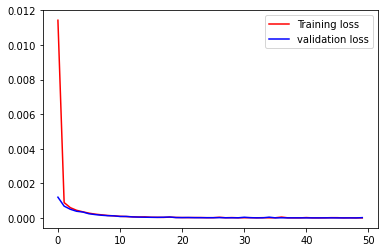

In [64]:
filepath = 'weights_32_res.hdf5'
checkpoint = ModelCheckpoint(filepath,monitor='val_loss',verbose=0,save_best_only=True,mode=min)

history=autoencoder.fit(train,train,epochs=50,batch_size=5,validation_split=0.1,callbacks=[checkpoint])

plt.plot(history.history['loss'],'r',label='Training loss')
plt.plot(history.history['val_loss'],'b',label='validation loss')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


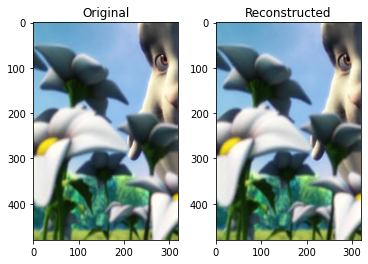

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


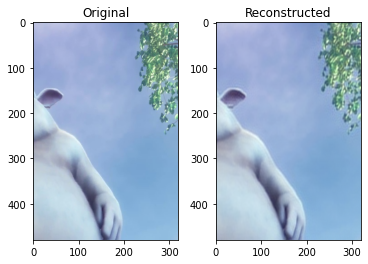

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


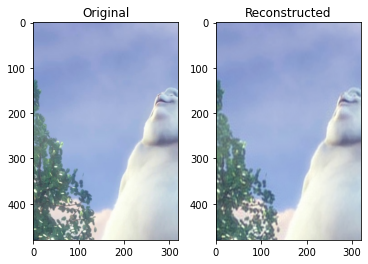

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


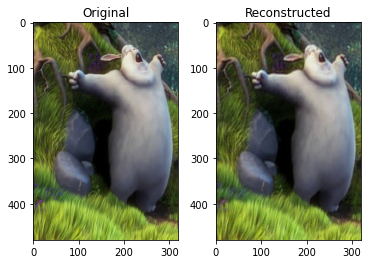

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


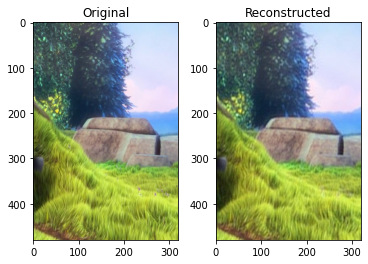

In [120]:
autoencoder.load_weights(filepath)

num = random.sample(range(0,len(test)),5)

for i in num:
    im = test[i]
    pred=autoencoder.predict(np.expand_dims(im,axis=0))
    plt.subplot(121)
    plt.imshow(im)
    plt.title('Original')
    
    plt.subplot(122)
    plt.imshow(pred[0,:,:,:])
    plt.title('Reconstructed')
    
    plt.show()

In [121]:
predicted=autoencoder.predict(test)
overall_ssim(test,predicted)

0.9531752183695954

In [122]:
import gc
pred = []
for i in range(len(images)):
    if i%10 == 0:
        print(i)
    imgs_new = np.expand_dims(images[i],axis=0)
    preds=autoencoder.predict(imgs_new)
    pred.append(preds)
    del(preds)
#     del(code)
    del(imgs_new)
    gc.collect()
    
pred1=np.array(pred)
pred1=pred1.reshape(pred1.shape[0],pred1.shape[2],pred1.shape[3],pred1.shape[4])
pred2 = pred1 * 255.

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470


In [123]:
overall_ssim(images,pred1)

0.9534750575883676

In [124]:
names1=[]
images1=[]
for i in range(len(pred2)):
    cv2.imwrite('frame_{}.jpg'.format(i),pred2[i])
    
for i in range(len(pred2)):
    ims = cv2.imread('frame_{}.jpg'.format(i))
    name = 'frame_{}.jpg'.format(i)
    names1.append(name)
    images1.append(ims)

In [125]:
count=0
for i in range(0,len(images1)-1,2):
    x1 = cv2.imread(names1[i])
    x2 = cv2.imread(names1[i+1])
    x3 = cv2.hconcat([x1,x2])
    try:
        os.remove(names1[i])
        os.remove(names1[i+1])
    except IndexError:
        print(i)
        break
    cv2.imwrite('frame_{}.jpg'.format(count),x3)
    count+=1

In [126]:
video = cv2.VideoWriter('recon1.avi', 0 , 25.0, (640,480))
for image in names1:
    video.write(cv2.imread(image))
cv2.destroyAllWindows()
video.release()

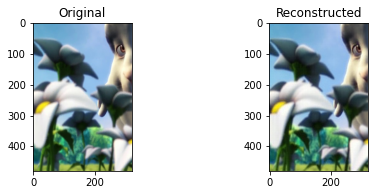

------------------------------ SSIM: 0.9670597438179875 ------------------------------


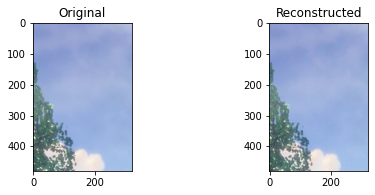

------------------------------ SSIM: 0.9869020551734972 ------------------------------


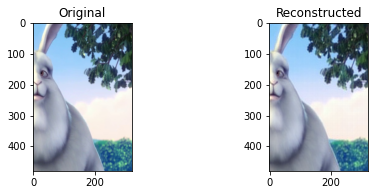

------------------------------ SSIM: 0.7777630441908637 ------------------------------


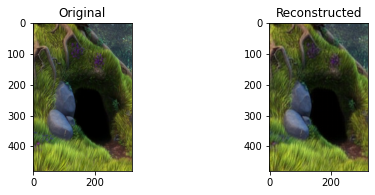

------------------------------ SSIM: 0.7459639307422464 ------------------------------


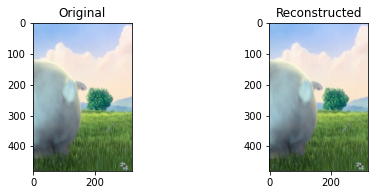

------------------------------ SSIM: 0.9831922345697223 ------------------------------


In [11]:
model.load_weights(filepath)

num_test = random.sample(range(0,len(test)),5)
for i in num_test:
    img = test[i]
    visualize(img,encoder,decoder)

In [12]:
bottle = encoder.predict(test)
predicted = decoder.predict(bottle)
overall_ssim(test,predicted)

0.9455565036856451

In [13]:
import gc
pred = []
for i in range(len(images)):
    if i%10 == 0:
        print(i)
    imgs_new = np.expand_dims(images[i],axis=0)
    code = encoder.predict(imgs_new)
    preds = decoder.predict(code)
    pred.append(preds)
    del(preds)
    del(code)
    del(imgs_new)
    gc.collect()
    
pred1=np.array(pred)
pred1=pred1.reshape(pred1.shape[0],pred1.shape[2],pred1.shape[3],pred1.shape[4])
pred2 = pred1 * 255.

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470


In [15]:
pred1.shape

(1478, 480, 320, 3)

In [16]:
overall_ssim(images,pred1)

0.9457414201215781

In [ ]:
p = r'C:\Users\Saad.LAKES\Desktop\Autoencoders\Videos\Results\ReconVideo_Frames'
p = p.replace('\\','/')

In [ ]:
p1=os.getcwd()
os.chdir(p)
os.getcwd()

In [ ]:
names1=[]
images1=[]
for i in range(len(pred2)):
    cv2.imwrite('frame_{}.jpg'.format(i),pred2[i])
    
for i in range(len(pred2)):
    ims = cv2.imread('frame_{}.jpg'.format(i))
    name = 'frame_{}.jpg'.format(i)
    names1.append(name)
    images1.append(ims)

In [ ]:
video = cv2.VideoWriter('recon.avi', 0 , 25.0, (320,480))
for image in names1:
    video.write(cv2.imread(image))
cv2.destroyAllWindows()
video.release()

In [ ]:
x1 = cv2.imread(names1[0])
x2 = cv2.imread(names1[1])
x3 = cv2.imread(names1[2])
x4 = cv2.imread(names1[3])

plt.subplot(141)
plt.imshow(x1)

plt.subplot(142)
plt.imshow(x2)

plt.subplot(143)
plt.imshow(x3)

plt.subplot(144)
plt.imshow(x4)

In [ ]:
x_1 = cv2.hconcat([x1,x2])
plt.imshow(x_1)

In [ ]:
os.getcwd()

In [ ]:
count=0
for i in range(0,len(images1)-1,2):
    x1 = cv2.imread(names1[i])
    x2 = cv2.imread(names1[i+1])
    x3 = cv2.hconcat([x1,x2])
    try:
        os.remove(names1[i])
        os.remove(names1[i+1])
    except IndexError:
        print(i)
        break
    cv2.imwrite('frame_{}.jpg'.format(count),x3)
    count+=1

In [ ]:
video = cv2.VideoWriter('recon.avi', 0 , 25.0, (640,480))
for image in names1:
    video.write(cv2.imread(image))
cv2.destroyAllWindows()
video.release()

In [ ]:
os.chdir('C:/Users/Saad.LAKES/Desktop/Autoencoders/Videos/Results/Video_Frames')

In [ ]:
video1 = cv2.VideoWriter('original.avi', 0 , 25.0, (640,480))
for image in names:
    video1.write(cv2.imread(image))
cv2.destroyAllWindows()
video1.release()

In [ ]:
plt.imshow(images1[0])

In [ ]:
plt.subplot(141)
plt.imshow(imCrop(images[1],2)[0])
plt.subplot(142)
plt.imshow(imCrop(images[1],2)[1])
# plt.subplot(143)
# plt.imshow(imCrop(images[1],4)[2])
# plt.subplot(144)
# plt.imshow(imCrop(images[1],4)[3])

In [ ]:
images[1].shape

In [ ]:
images[1][540,480]

In [ ]:
x=image_slicer.slice('frame_1.jpg',16,save=False)

In [ ]:
from PIL import ImageDraw, ImageFont

In [ ]:
for tile in x:
    overlay = ImageDraw.Draw(tile.image)

In [ ]:
overlay

In [ ]:
np.asarray(x[1].image)

In [ ]:
# filterss = 16
# SSIM =0.90
# # The encoder
# encoder = Sequential()
# encoder.add(InputLayer((480,320,3)))
# encoder.add(Conv2D(filters=filterss,kernel_size=3,strides=2,padding='same'))
# encoder.add(Conv2D(filters=filterss,kernel_size=3,strides=2,padding='same'))
# encoder.add(Conv2D(filters=filterss,kernel_size=3,strides=2,padding='same'))
# encoder.add(Conv2D(filters=filterss,kernel_size=3,strides=2,padding='same'))


# # The decoder
# decoder = Sequential()
# decoder.add(InputLayer((30,20,filterss)))
# decoder.add(Conv2DTranspose(filters=filterss,kernel_size=3,strides=2,padding='same'))
# decoder.add(Conv2DTranspose(filters=filterss,kernel_size=3,strides=2,padding='same'))
# decoder.add(Conv2DTranspose(filters=filterss,kernel_size=3,strides=2,padding='same'))
# decoder.add(Conv2DTranspose(filters=3,kernel_size=3,strides=2,padding='same'))